In [111]:
## Import Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from PyAstronomy.pyasl import foldAt


## Optimize for Jupyter Notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

RV_data = np.loadtxt('RV_data.txt',skiprows=16,usecols=(0,1,2,3,4))
lightcurve_data = np.loadtxt('lightcurve_data.txt',skiprows=18,usecols=(0,1))

In [112]:
BJD = RV_data[:,0]
Rad_Vel = RV_data[:,1]
Rad_Vel_Uncert = RV_data[:,2]
Bisect_Span = RV_data[:,3]
BS_Uncert = RV_data[:,4]

HJD = lightcurve_data[:,0]
flux = lightcurve_data[:,1]

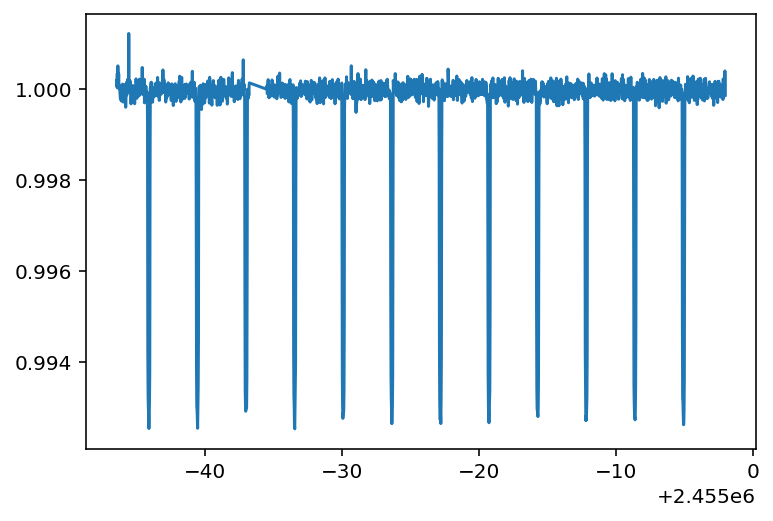

In [113]:
plt.plot(HJD, flux)

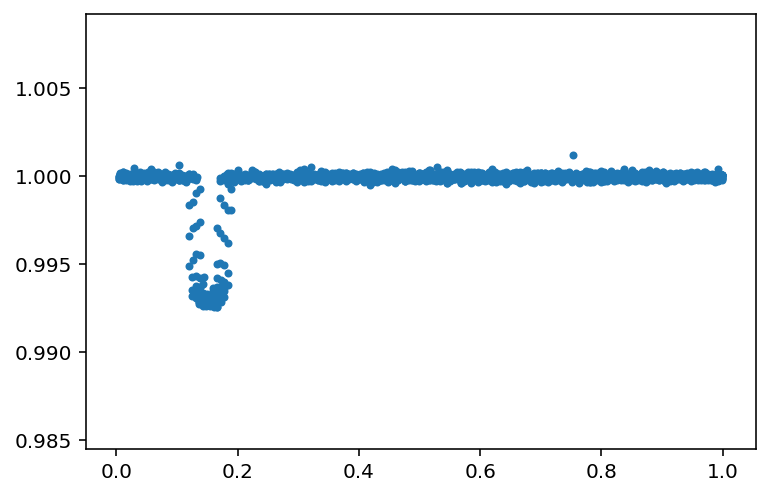

In [77]:
pred_period = 3.556
transit_time = pred_period/2
new_HJD = HJD - transit_time
#plt.plot(HJD, flux)

phases = foldAt(new_HJD, period=pred_period, T0=HJD[0], getEpoch=False)

# Sort with respect to phase
# First, get the order of indices ...
sortIndi = np.argsort(phases)
# ... and, second, rearrange the arrays.
phases = phases[sortIndi]
new_flux = flux[sortIndi]

# Plot the result
plt.scatter(phases, new_flux, marker='.')
#plt.xlim(0.4,0.8)
plt.show()

In [78]:
def lnprior(theta):
    # The parameters are stored as a vector of values, so unpack them
    period, width, t_first, amp_I, ti = theta
    # We're using only uniform priors, and only eps has a lower bound
    if period < 0 or period > 100:
        return -np.inf
    if width > 20 or width < 0:
        return -np.inf
    if t_first < 0 or t_first > 50:
        return -np.inf
    if amp_I > 0.2 or amp_I < -0.2:
        return -np.inf
    return 0

def lnlike(theta, date, y):
    
    ## Parameters
    period, width, t_first, amp_I, ti = theta 
    
    model = []
    
    for i in range(0, len(model)):
        
    
    # the likelihood is sum of the lot of normal distributions
    denom = np.sqrt(2*np.pi)
    
    ## compute the likelihood, but divide out fact.
    lp = np.sum((-(y - model)**2.0/(2)) - np.log(denom))
    return lp

def lnprob(theta, date, y):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, date, intensity, y)

def dip_model(time_index, t_first , width , period):

    n = 1
    while True:
        time = time_index - n * period
        if time < t_first:
            return False
        elif time > t_first + n*period and time < t_first + n*period + width:
            return True
        n += 1

SyntaxError: invalid syntax (<ipython-input-78-9471bcc131d2>, line 22)